# Code Description 
## Exploratory Data Analysis Code 
- This notebook tackles all code related to loading and training the SCC models

## Part 0 : Code Imports

In [9]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import torch
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms as T
from PIL import Image
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from thop import profile
import torchvision.models as models
from transformers import ViTForImageClassification
from torchsummary import summary
import timm
from timm import create_model 
import torch.nn as nn
import torch.optim as optim
import gc
from tqdm.auto import tqdm
from ptflops import get_model_complexity_info
from torch.cuda.amp import autocast, GradScaler

## Dataset Loading Methods

In [10]:
def load_image_paths(data_dir):
    image_paths, labels = [], []
    class_names = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
    label_map = {name: idx for idx, name in enumerate(class_names)}
    valid_exts = ('.png', '.jpg', '.jpeg', '.bmp', '.tiff')

    for class_name in class_names:
        class_folder = os.path.join(data_dir, class_name)
        for filename in os.listdir(class_folder):
            if filename.lower().endswith(valid_exts):
                file_path = os.path.join(class_folder, filename)
                try:
                    Image.open(file_path).verify()
                    image_paths.append(file_path)
                    labels.append(label_map[class_name])
                except Exception:
                    print(f"⚠️ Skipping corrupted file: {file_path}")

    return np.array(image_paths), np.array(labels, dtype=np.int64), class_names

class CustomImageDataset(Dataset):
    def __init__(self, image_paths, labels, img_size=(224, 224), augment=False):
        self.image_paths = image_paths
        self.labels = labels
        if augment:
            self.transform = T.Compose([
                T.Resize((256, 256)),
                T.RandomCrop(img_size),
                T.RandomHorizontalFlip(),
                T.RandomVerticalFlip(),
                T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
                T.ToTensor(),
                T.Normalize(mean=[0.5]*3, std=[0.5]*3)
            ])
        else:
            self.transform = T.Compose([
                T.Resize(img_size),
                T.ToTensor(),
                T.Normalize(mean=[0.5]*3, std=[0.5]*3)
            ])

    def __len__(self): return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        img = self.transform(img)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return img, label


def get_dataloader(image_paths, labels, batch_size=32, augment=False, img_size=(224, 224), shuffle=True):
    ds = CustomImageDataset(image_paths, labels, img_size=img_size, augment=augment)
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle, num_workers=0, pin_memory=True)

## Model Builder

In [11]:
import torch.nn as nn
from torchvision import models
from timm import create_model  

def build_model(model_name, num_classes=2, pretrained=False):
    model_name = model_name.lower()
    
    if model_name == "convnext_tiny":
        model = models.convnext_tiny(pretrained=pretrained)
        in_features = model.classifier[2].in_features
        model.classifier[2] = nn.Linear(in_features, num_classes)
    
    elif model_name == "vit_base_patch16_224":
        model = models.vit_b_16(pretrained=pretrained)
        in_features = model.heads.head.in_features
        model.heads.head = nn.Linear(in_features, num_classes)
    
    elif model_name.startswith("coatnet"):
        model = create_model(model_name, pretrained=pretrained, num_classes=num_classes)
    
    else:
        raise ValueError(f"Unknown model name: {model_name}")
    
    return model


## Model Measurements

In [12]:
def print_model_complexity(model, device, input_size=(3, 224, 224), print_layers=True):
    model = model.to(device)
    x = torch.randn(1, *input_size).to(device)
    flops, params = profile(model, inputs=(x,), verbose=False)
    print(f"🧠 Parameters: {params/1e6:.2f} M")
    print(f"🚀 FLOPs (1x{input_size[-1]}x{input_size[-1]}): {flops/1e9:.2f} GFLOPs")
    if print_layers:
        try:
            summary(model, input_size=input_size, device=str(device))
        except Exception as e:
            print(f"(summary skipped: {e})")


def measure_latency_throughput(model, device, batch_size=32, input_size=(3,224,224), repeats=50):
    model.eval()
    dummy = torch.randn(batch_size, *input_size, device=device)

    with torch.no_grad():
        for _ in range(5): _ = model(dummy)
    if device.type == "cuda": torch.cuda.synchronize()
    start = time.time()
    with torch.no_grad():
        for _ in range(repeats): _ = model(dummy)
    if device.type == "cuda": torch.cuda.synchronize()
    total = time.time() - start
    avg_latency_ms = (total / repeats) * 1000.0
    throughput = (batch_size * repeats) / total
    print(f"⚡ Avg Latency: {avg_latency_ms:.2f} ms | 📈 Throughput: {throughput:.2f} img/s")

## Model Training and Evaluation Utilities

In [13]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad(set_to_none=True)
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        preds = outputs.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return running_loss / total, correct / total


@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss, total = 0.0, 0
    all_preds, all_labels = [], []

    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        running_loss += loss.item() * imgs.size(0)
        preds = outputs.argmax(1)

        total += labels.size(0)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    val_loss = running_loss / total
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    rec = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    return val_loss, acc, prec, rec, f1


def plot_history(history, title, out_png):
    plt.figure(figsize=(10,4))
    plt.suptitle(title)
    plt.subplot(1,2,1)
    plt.plot(history['train_acc'], label='Train Acc')
    plt.plot(history['val_acc'], label='Val Acc')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.grid(True); plt.title('Accuracy')

    plt.subplot(1,2,2)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.grid(True); plt.title('Loss')

    plt.tight_layout(rect=[0,0,1,0.95])
    plt.savefig(out_png, dpi=140)
    plt.show()

## Training Codes

In [14]:
def run_phase(model, phase_name, train_loader, val_loader, device, epochs=10, lr=1e-4, weight_decay=1e-4, out_dir="models", use_amp=True):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scaler = GradScaler() if use_amp else None
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    os.makedirs(out_dir, exist_ok=True)
    best_acc, best_state_path, best_full_path = 0.0, os.path.join(out_dir, f"{phase_name}_best.pth"), os.path.join(out_dir, f"{phase_name}_best_full.pth")

    print(f"\n▶️ Phase: {phase_name} | epochs={epochs} | lr={lr} | weight_decay={weight_decay}")
    
    for epoch in range(1, epochs+1):
        print(f"\n--- Epoch {epoch}/{epochs} ---")
        model.train()
        running_loss, running_correct, total = 0.0, 0, 0

        for i, (inputs, targets) in enumerate(train_loader):
            try:
                inputs, targets = inputs.to(device), targets.to(device)
                optimizer.zero_grad(set_to_none=True)

                if use_amp:
                    with autocast():
                        outputs = model(inputs)
                        loss = criterion(outputs, targets)
                    scaler.scale(loss).backward()
                    scaler.step(optimizer)
                    scaler.update()
                else:
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                    loss.backward()
                    optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                preds = outputs.argmax(1)
                running_correct += (preds == targets).sum().item()
                total += targets.size(0)

                if i % 5 == 0:
                    print(f"Batch {i}/{len(train_loader)} | Loss: {running_loss/total:.4f} | Acc: {running_correct/total:.4f}")

            except Exception as e:
                print(f"⚠️ Skipping batch {i} due to error: {e}")

        tr_loss = running_loss / max(total, 1)
        tr_acc = running_correct / max(total, 1)

        # Validation
        va_loss, va_acc, va_prec, va_rec, va_f1 = evaluate(model, val_loader, criterion, device)

        history['train_loss'].append(tr_loss)
        history['train_acc'].append(tr_acc)
        history['val_loss'].append(va_loss)
        history['val_acc'].append(va_acc)

        print(f"Epoch {epoch:02d} | Train Loss: {tr_loss:.4f}, Acc: {tr_acc:.4f} | "
              f"Val Loss: {va_loss:.4f}, Acc: {va_acc:.4f}, P: {va_prec:.4f}, R: {va_rec:.4f}, F1: {va_f1:.4f}")

        # Save best model
        if va_acc > best_acc:
            best_acc = va_acc
            # Save state dict
            torch.save(model.state_dict(), best_state_path)
            # Save full model
            torch.save(model, best_full_path)

    return history, best_acc, best_state_path, best_full_path


def run_kfold_training(
    model_name: str,
    dataset_path: str,
    k: int = 5,
    epochs_frozen: int = 10,
    epochs_ft: int = 20,
    batch_size: int = 32,
    img_size=(224,224),
    base_lr: float = 1e-3,
    ft_lr: float = 1e-4,
    weight_decay: float = 1e-4,
    pretrained=True
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    image_paths, labels, class_names = load_image_paths(dataset_path)
    num_classes = len(class_names)

    model_dir = os.path.join("models", model_name)
    os.makedirs(model_dir, exist_ok=True)

    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    all_results = []
    fold_idx = 0

    for train_idx, val_idx in skf.split(image_paths, labels):
        fold_idx += 1
        print(f"\n==================== Fold {fold_idx}/{k} — {model_name} ====================")

        fold_dir = os.path.join(model_dir, f"fold{fold_idx}")
        os.makedirs(fold_dir, exist_ok=True)

        train_loader = get_dataloader(image_paths[train_idx], labels[train_idx],
                                      batch_size=batch_size, augment=True, img_size=img_size, shuffle=True)
        val_loader = get_dataloader(image_paths[val_idx], labels[val_idx],
                                    batch_size=batch_size, augment=False, img_size=img_size, shuffle=False)

        model = build_model(model_name, num_classes=num_classes, pretrained=pretrained).to(device)

        # Freeze backbone
        for name, param in model.named_parameters():
            param.requires_grad = False
        for name, param in model.named_parameters():
            if any(key in name for key in ['head', 'classifier', 'fc', 'bn', 'norm']):
                param.requires_grad = True

        # Phase 1: Frozen backbone
        hist_frozen, best_acc_frozen, best_state_frozen, best_full_frozen = run_phase(
            model, phase_name=f"fold{fold_idx}_frozen",
            train_loader=train_loader, val_loader=val_loader,
            device=device, epochs=epochs_frozen, lr=base_lr,
            weight_decay=weight_decay, out_dir=fold_dir
        )

        model.load_state_dict(torch.load(best_state_frozen, map_location=device))

        # Phase 2: Fine-tune all layers
        for p in model.parameters(): p.requires_grad = True
        hist_ft, best_acc_ft, best_state_ft, best_full_ft = run_phase(
            model, phase_name=f"fold{fold_idx}_finetune",
            train_loader=train_loader, val_loader=val_loader,
            device=device, epochs=epochs_ft, lr=ft_lr,
            weight_decay=weight_decay, out_dir=fold_dir
        )

        model.load_state_dict(torch.load(best_state_ft, map_location=device))
        val_loss, val_acc, val_prec, val_rec, val_f1 = evaluate(model, val_loader, nn.CrossEntropyLoss(), device)

        all_results.append({
            "fold": fold_idx,
            "best_acc_frozen": best_acc_frozen,
            "best_acc_finetune": best_acc_ft,
            "final_val_acc": val_acc,
            "final_val_precision": val_prec,
            "final_val_recall": val_rec,
            "final_val_f1": val_f1,
            "best_ckpt_frozen_state": best_state_frozen,
            "best_ckpt_frozen_full": best_full_frozen,
            "best_ckpt_finetune_state": best_state_ft,
            "best_ckpt_finetune_full": best_full_ft
        })

        # Cleanup
        del model, train_loader, val_loader
        if device.type == "cuda": torch.cuda.empty_cache()
        gc.collect()

    # Save results
    df = pd.DataFrame(all_results)
    csv_name = os.path.join(model_dir, f"{model_name}_kfold_results.csv")
    df.to_csv(csv_name, index=False)
    print(f"\n📄 Saved results: {csv_name}")

    plt.figure(figsize=(6,4))
    plt.plot(df["fold"], df["final_val_acc"], marker='o')
    plt.xlabel("Fold"); plt.ylabel("Final Val Accuracy")
    plt.title(f"{model_name} — Accuracy Across Folds (Fine-tuned best)")
    plt.grid(True)
    plt.savefig(os.path.join(model_dir, f"{model_name}_kfold_final_acc.png"), dpi=140)
    plt.show()


## Usage

In [15]:
dataset_path = "Dataset" 

- ConVNexT Tiny


==================== Fold 1/5 — convnext_tiny ====================


c:\Users\cauba\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\cauba\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler() if use_amp else None



▶️ Phase: fold1_frozen | epochs=10 | lr=0.001 | weight_decay=0.0001

--- Epoch 1/10 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.6867 | Acc: 0.5625
Batch 5/21 | Loss: 0.6102 | Acc: 0.6875
Batch 10/21 | Loss: 0.5730 | Acc: 0.6903
Batch 15/21 | Loss: 0.5559 | Acc: 0.7031
Batch 20/21 | Loss: 0.5473 | Acc: 0.7039
Epoch 01 | Train Loss: 0.5473, Acc: 0.7039 | Val Loss: 0.4043, Acc: 0.8133, P: 0.8093, R: 0.8172, F1: 0.8108

--- Epoch 2/10 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.3567 | Acc: 0.8438
Batch 5/21 | Loss: 0.4255 | Acc: 0.8333
Batch 10/21 | Loss: 0.4101 | Acc: 0.8324
Batch 15/21 | Loss: 0.4005 | Acc: 0.8340
Batch 20/21 | Loss: 0.3857 | Acc: 0.8459
Epoch 02 | Train Loss: 0.3857, Acc: 0.8459 | Val Loss: 0.2971, Acc: 0.8916, P: 0.8971, R: 0.8800, F1: 0.8862

--- Epoch 3/10 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.3927 | Acc: 0.8438
Batch 5/21 | Loss: 0.3690 | Acc: 0.8385
Batch 10/21 | Loss: 0.3610 | Acc: 0.8551
Batch 15/21 | Loss: 0.3531 | Acc: 0.8633
Batch 20/21 | Loss: 0.3471 | Acc: 0.8640
Epoch 03 | Train Loss: 0.3471, Acc: 0.8640 | Val Loss: 0.2724, Acc: 0.9096, P: 0.9184, R: 0.8976, F1: 0.9049

--- Epoch 4/10 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.3437 | Acc: 0.8438
Batch 5/21 | Loss: 0.3642 | Acc: 0.8281
Batch 10/21 | Loss: 0.3314 | Acc: 0.8551
Batch 15/21 | Loss: 0.3224 | Acc: 0.8613
Batch 20/21 | Loss: 0.3171 | Acc: 0.8701
Epoch 04 | Train Loss: 0.3171, Acc: 0.8701 | Val Loss: 0.2445, Acc: 0.9157, P: 0.9121, R: 0.9153, F1: 0.9135

--- Epoch 5/10 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.2672 | Acc: 0.8750
Batch 5/21 | Loss: 0.2922 | Acc: 0.8646
Batch 10/21 | Loss: 0.2936 | Acc: 0.8693
Batch 15/21 | Loss: 0.2909 | Acc: 0.8711
Batch 20/21 | Loss: 0.2890 | Acc: 0.8716
Epoch 05 | Train Loss: 0.2890, Acc: 0.8716 | Val Loss: 0.2333, Acc: 0.9096, P: 0.9077, R: 0.9059, F1: 0.9068

--- Epoch 6/10 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.2427 | Acc: 0.9062
Batch 5/21 | Loss: 0.2563 | Acc: 0.8906
Batch 10/21 | Loss: 0.2719 | Acc: 0.8835
Batch 15/21 | Loss: 0.2628 | Acc: 0.8926
Batch 20/21 | Loss: 0.2709 | Acc: 0.8912
Epoch 06 | Train Loss: 0.2709, Acc: 0.8912 | Val Loss: 0.2329, Acc: 0.8916, P: 0.8870, R: 0.8947, F1: 0.8896

--- Epoch 7/10 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.2793 | Acc: 0.8750
Batch 5/21 | Loss: 0.2562 | Acc: 0.8958
Batch 10/21 | Loss: 0.2380 | Acc: 0.9062
Batch 15/21 | Loss: 0.2433 | Acc: 0.9043
Batch 20/21 | Loss: 0.2564 | Acc: 0.8927
Epoch 07 | Train Loss: 0.2564, Acc: 0.8927 | Val Loss: 0.2086, Acc: 0.9277, P: 0.9273, R: 0.9235, F1: 0.9253

--- Epoch 8/10 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.1545 | Acc: 0.9688
Batch 5/21 | Loss: 0.2058 | Acc: 0.9375
Batch 10/21 | Loss: 0.2131 | Acc: 0.9375
Batch 15/21 | Loss: 0.2195 | Acc: 0.9219
Batch 20/21 | Loss: 0.2510 | Acc: 0.8988
Epoch 08 | Train Loss: 0.2510, Acc: 0.8988 | Val Loss: 0.2051, Acc: 0.9096, P: 0.9053, R: 0.9122, F1: 0.9079

--- Epoch 9/10 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.2982 | Acc: 0.8750
Batch 5/21 | Loss: 0.2421 | Acc: 0.9115
Batch 10/21 | Loss: 0.2377 | Acc: 0.9091
Batch 15/21 | Loss: 0.2213 | Acc: 0.9199
Batch 20/21 | Loss: 0.2404 | Acc: 0.9048
Epoch 09 | Train Loss: 0.2404, Acc: 0.9048 | Val Loss: 0.1931, Acc: 0.9217, P: 0.9221, R: 0.9163, F1: 0.9189

--- Epoch 10/10 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.1576 | Acc: 0.9375
Batch 5/21 | Loss: 0.2587 | Acc: 0.9010
Batch 10/21 | Loss: 0.2444 | Acc: 0.9006
Batch 15/21 | Loss: 0.2421 | Acc: 0.9062
Batch 20/21 | Loss: 0.2452 | Acc: 0.9018
Epoch 10 | Train Loss: 0.2452, Acc: 0.9018 | Val Loss: 0.1960, Acc: 0.9277, P: 0.9256, R: 0.9256, F1: 0.9256

▶️ Phase: fold1_finetune | epochs=20 | lr=0.0001 | weight_decay=0.0001

--- Epoch 1/20 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_state_frozen, map_loc

Batch 0/21 | Loss: 0.3407 | Acc: 0.8125
Batch 5/21 | Loss: 0.3029 | Acc: 0.8490
Batch 10/21 | Loss: 0.2660 | Acc: 0.8864
Batch 15/21 | Loss: 0.3002 | Acc: 0.8750
Batch 20/21 | Loss: 0.3050 | Acc: 0.8686
Epoch 01 | Train Loss: 0.3050, Acc: 0.8686 | Val Loss: 0.2418, Acc: 0.8855, P: 0.8830, R: 0.8937, F1: 0.8843

--- Epoch 2/20 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.2636 | Acc: 0.9062
Batch 5/21 | Loss: 0.2482 | Acc: 0.9062
Batch 10/21 | Loss: 0.2421 | Acc: 0.9062
Batch 15/21 | Loss: 0.2494 | Acc: 0.9004
Batch 20/21 | Loss: 0.2477 | Acc: 0.8988
Epoch 02 | Train Loss: 0.2477, Acc: 0.8988 | Val Loss: 0.1897, Acc: 0.9398, P: 0.9533, R: 0.9275, F1: 0.9364

--- Epoch 3/20 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.1426 | Acc: 0.8750
Batch 5/21 | Loss: 0.1498 | Acc: 0.9271
Batch 10/21 | Loss: 0.1726 | Acc: 0.9261
Batch 15/21 | Loss: 0.1481 | Acc: 0.9395
Batch 20/21 | Loss: 0.1456 | Acc: 0.9441
Epoch 03 | Train Loss: 0.1456, Acc: 0.9441 | Val Loss: 0.1529, Acc: 0.9337, P: 0.9311, R: 0.9328, F1: 0.9319

--- Epoch 4/20 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.0721 | Acc: 0.9688
Batch 5/21 | Loss: 0.0812 | Acc: 0.9531
Batch 10/21 | Loss: 0.0795 | Acc: 0.9631
Batch 15/21 | Loss: 0.0970 | Acc: 0.9629
Batch 20/21 | Loss: 0.0995 | Acc: 0.9622
Epoch 04 | Train Loss: 0.0995, Acc: 0.9622 | Val Loss: 0.1876, Acc: 0.9096, P: 0.9054, R: 0.9143, F1: 0.9082

--- Epoch 5/20 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.1128 | Acc: 0.9688
Batch 5/21 | Loss: 0.1106 | Acc: 0.9583
Batch 10/21 | Loss: 0.0999 | Acc: 0.9602
Batch 15/21 | Loss: 0.0865 | Acc: 0.9648
Batch 20/21 | Loss: 0.0819 | Acc: 0.9668
Epoch 05 | Train Loss: 0.0819, Acc: 0.9668 | Val Loss: 0.1801, Acc: 0.9217, P: 0.9187, R: 0.9204, F1: 0.9196

--- Epoch 6/20 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.0490 | Acc: 0.9688
Batch 5/21 | Loss: 0.0634 | Acc: 0.9688
Batch 10/21 | Loss: 0.0567 | Acc: 0.9801
Batch 15/21 | Loss: 0.0570 | Acc: 0.9785
Batch 20/21 | Loss: 0.0546 | Acc: 0.9819
Epoch 06 | Train Loss: 0.0546, Acc: 0.9819 | Val Loss: 0.1657, Acc: 0.9398, P: 0.9357, R: 0.9443, F1: 0.9387

--- Epoch 7/20 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.0328 | Acc: 1.0000
Batch 5/21 | Loss: 0.0503 | Acc: 0.9896
Batch 10/21 | Loss: 0.0571 | Acc: 0.9801
Batch 15/21 | Loss: 0.0500 | Acc: 0.9824
Batch 20/21 | Loss: 0.0531 | Acc: 0.9804
Epoch 07 | Train Loss: 0.0531, Acc: 0.9804 | Val Loss: 0.2563, Acc: 0.9157, P: 0.9126, R: 0.9237, F1: 0.9147

--- Epoch 8/20 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.0791 | Acc: 0.9688
Batch 5/21 | Loss: 0.0378 | Acc: 0.9896
Batch 10/21 | Loss: 0.0409 | Acc: 0.9886
Batch 15/21 | Loss: 0.0404 | Acc: 0.9902
Batch 20/21 | Loss: 0.0376 | Acc: 0.9879
Epoch 08 | Train Loss: 0.0376, Acc: 0.9879 | Val Loss: 0.1845, Acc: 0.9337, P: 0.9311, R: 0.9328, F1: 0.9319

--- Epoch 9/20 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.0143 | Acc: 1.0000
Batch 5/21 | Loss: 0.0495 | Acc: 0.9792
Batch 10/21 | Loss: 0.0372 | Acc: 0.9858
Batch 15/21 | Loss: 0.0465 | Acc: 0.9805
Batch 20/21 | Loss: 0.0496 | Acc: 0.9789
Epoch 09 | Train Loss: 0.0496, Acc: 0.9789 | Val Loss: 0.1867, Acc: 0.9398, P: 0.9398, R: 0.9359, F1: 0.9377

--- Epoch 10/20 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.0135 | Acc: 1.0000
Batch 5/21 | Loss: 0.0819 | Acc: 0.9740
Batch 10/21 | Loss: 0.0574 | Acc: 0.9830
Batch 15/21 | Loss: 0.0557 | Acc: 0.9844
Batch 20/21 | Loss: 0.0488 | Acc: 0.9879
Epoch 10 | Train Loss: 0.0488, Acc: 0.9879 | Val Loss: 0.1807, Acc: 0.9398, P: 0.9398, R: 0.9359, F1: 0.9377

--- Epoch 11/20 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.0056 | Acc: 1.0000
Batch 5/21 | Loss: 0.0202 | Acc: 0.9948
Batch 10/21 | Loss: 0.0159 | Acc: 0.9972
Batch 15/21 | Loss: 0.0256 | Acc: 0.9961
Batch 20/21 | Loss: 0.0220 | Acc: 0.9955
Epoch 11 | Train Loss: 0.0220, Acc: 0.9955 | Val Loss: 0.2239, Acc: 0.9157, P: 0.9132, R: 0.9132, F1: 0.9132

--- Epoch 12/20 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.0028 | Acc: 1.0000
Batch 5/21 | Loss: 0.0212 | Acc: 0.9948
Batch 10/21 | Loss: 0.0209 | Acc: 0.9943
Batch 15/21 | Loss: 0.0198 | Acc: 0.9941
Batch 20/21 | Loss: 0.0213 | Acc: 0.9940
Epoch 12 | Train Loss: 0.0213, Acc: 0.9940 | Val Loss: 0.1668, Acc: 0.9639, P: 0.9649, R: 0.9607, F1: 0.9626

--- Epoch 13/20 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.0020 | Acc: 1.0000
Batch 5/21 | Loss: 0.0124 | Acc: 1.0000
Batch 10/21 | Loss: 0.0161 | Acc: 0.9943
Batch 15/21 | Loss: 0.0129 | Acc: 0.9961
Batch 20/21 | Loss: 0.0188 | Acc: 0.9940
Epoch 13 | Train Loss: 0.0188, Acc: 0.9940 | Val Loss: 0.2586, Acc: 0.9337, P: 0.9296, R: 0.9370, F1: 0.9324

--- Epoch 14/20 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.0154 | Acc: 1.0000
Batch 5/21 | Loss: 0.0129 | Acc: 1.0000
Batch 10/21 | Loss: 0.0189 | Acc: 0.9943
Batch 15/21 | Loss: 0.0180 | Acc: 0.9922
Batch 20/21 | Loss: 0.0161 | Acc: 0.9924
Epoch 14 | Train Loss: 0.0161, Acc: 0.9924 | Val Loss: 0.2271, Acc: 0.9458, P: 0.9473, R: 0.9411, F1: 0.9438

--- Epoch 15/20 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.0030 | Acc: 1.0000
Batch 5/21 | Loss: 0.0264 | Acc: 0.9948
Batch 10/21 | Loss: 0.0221 | Acc: 0.9943
Batch 15/21 | Loss: 0.0323 | Acc: 0.9902
Batch 20/21 | Loss: 0.0383 | Acc: 0.9879
Epoch 15 | Train Loss: 0.0383, Acc: 0.9879 | Val Loss: 0.3726, Acc: 0.8855, P: 0.8866, R: 0.8979, F1: 0.8848

--- Epoch 16/20 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.0581 | Acc: 0.9688
Batch 5/21 | Loss: 0.0344 | Acc: 0.9844
Batch 10/21 | Loss: 0.0284 | Acc: 0.9915
Batch 15/21 | Loss: 0.0262 | Acc: 0.9922
Batch 20/21 | Loss: 0.0396 | Acc: 0.9894
Epoch 16 | Train Loss: 0.0396, Acc: 0.9894 | Val Loss: 0.2358, Acc: 0.9217, P: 0.9221, R: 0.9163, F1: 0.9189

--- Epoch 17/20 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.0609 | Acc: 0.9688
Batch 5/21 | Loss: 0.0400 | Acc: 0.9844
Batch 10/21 | Loss: 0.0315 | Acc: 0.9886
Batch 15/21 | Loss: 0.0292 | Acc: 0.9883
Batch 20/21 | Loss: 0.0249 | Acc: 0.9909
Epoch 17 | Train Loss: 0.0249, Acc: 0.9909 | Val Loss: 0.2373, Acc: 0.9157, P: 0.9117, R: 0.9216, F1: 0.9144

--- Epoch 18/20 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.0217 | Acc: 1.0000
Batch 5/21 | Loss: 0.0453 | Acc: 0.9844
Batch 10/21 | Loss: 0.0377 | Acc: 0.9858
Batch 15/21 | Loss: 0.0334 | Acc: 0.9863
Batch 20/21 | Loss: 0.0319 | Acc: 0.9879
Epoch 18 | Train Loss: 0.0319, Acc: 0.9879 | Val Loss: 0.5108, Acc: 0.8976, P: 0.9193, R: 0.8789, F1: 0.8902

--- Epoch 19/20 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.0054 | Acc: 1.0000
Batch 5/21 | Loss: 0.0356 | Acc: 0.9792
Batch 10/21 | Loss: 0.0452 | Acc: 0.9830
Batch 15/21 | Loss: 0.0341 | Acc: 0.9883
Batch 20/21 | Loss: 0.0332 | Acc: 0.9864
Epoch 19 | Train Loss: 0.0332, Acc: 0.9864 | Val Loss: 0.2162, Acc: 0.9458, P: 0.9418, R: 0.9494, F1: 0.9447

--- Epoch 20/20 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.0080 | Acc: 1.0000
Batch 5/21 | Loss: 0.0097 | Acc: 1.0000
Batch 10/21 | Loss: 0.0128 | Acc: 0.9943
Batch 15/21 | Loss: 0.0135 | Acc: 0.9941
Batch 20/21 | Loss: 0.0177 | Acc: 0.9940
Epoch 20 | Train Loss: 0.0177, Acc: 0.9940 | Val Loss: 0.2139, Acc: 0.9337, P: 0.9301, R: 0.9349, F1: 0.9322


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:135: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_state_ft, map_locatio


==================== Fold 2/5 — convnext_tiny ====================


c:\Users\cauba\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\cauba\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler() if use_amp else None



▶️ Phase: fold2_frozen | epochs=10 | lr=0.001 | weight_decay=0.0001

--- Epoch 1/10 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.7048 | Acc: 0.5938
Batch 5/21 | Loss: 0.6057 | Acc: 0.6562
Batch 10/21 | Loss: 0.5648 | Acc: 0.7074
Batch 15/21 | Loss: 0.5319 | Acc: 0.7363
Batch 20/21 | Loss: 0.5070 | Acc: 0.7508
Epoch 01 | Train Loss: 0.5070, Acc: 0.7508 | Val Loss: 0.3872, Acc: 0.7952, P: 0.8010, R: 0.7745, F1: 0.7812

--- Epoch 2/10 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.4793 | Acc: 0.7500
Batch 5/21 | Loss: 0.4120 | Acc: 0.8281
Batch 10/21 | Loss: 0.4019 | Acc: 0.8438
Batch 15/21 | Loss: 0.3854 | Acc: 0.8457
Batch 20/21 | Loss: 0.3759 | Acc: 0.8505
Epoch 02 | Train Loss: 0.3759, Acc: 0.8505 | Val Loss: 0.3188, Acc: 0.8614, P: 0.8592, R: 0.8543, F1: 0.8564

--- Epoch 3/10 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.3522 | Acc: 0.8438
Batch 5/21 | Loss: 0.3138 | Acc: 0.8750
Batch 10/21 | Loss: 0.3049 | Acc: 0.8835
Batch 15/21 | Loss: 0.3076 | Acc: 0.8809
Batch 20/21 | Loss: 0.3110 | Acc: 0.8807
Epoch 03 | Train Loss: 0.3110, Acc: 0.8807 | Val Loss: 0.2917, Acc: 0.8916, P: 0.8875, R: 0.8905, F1: 0.8888

--- Epoch 4/10 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.2557 | Acc: 0.9062
Batch 5/21 | Loss: 0.3175 | Acc: 0.8698
Batch 10/21 | Loss: 0.2839 | Acc: 0.8920
Batch 15/21 | Loss: 0.3113 | Acc: 0.8711
Batch 20/21 | Loss: 0.3082 | Acc: 0.8761
Epoch 04 | Train Loss: 0.3082, Acc: 0.8761 | Val Loss: 0.2966, Acc: 0.8735, P: 0.8698, R: 0.8792, F1: 0.8718

--- Epoch 5/10 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.2563 | Acc: 0.8750
Batch 5/21 | Loss: 0.2711 | Acc: 0.8854
Batch 10/21 | Loss: 0.2538 | Acc: 0.8949
Batch 15/21 | Loss: 0.2584 | Acc: 0.8945
Batch 20/21 | Loss: 0.2777 | Acc: 0.8882
Epoch 05 | Train Loss: 0.2777, Acc: 0.8882 | Val Loss: 0.2557, Acc: 0.8916, P: 0.8898, R: 0.8863, F1: 0.8879

--- Epoch 6/10 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.3303 | Acc: 0.8750
Batch 5/21 | Loss: 0.2762 | Acc: 0.8698
Batch 10/21 | Loss: 0.2727 | Acc: 0.8920
Batch 15/21 | Loss: 0.2811 | Acc: 0.8789
Batch 20/21 | Loss: 0.2655 | Acc: 0.8897
Epoch 06 | Train Loss: 0.2655, Acc: 0.8897 | Val Loss: 0.2624, Acc: 0.8976, P: 0.9053, R: 0.8852, F1: 0.8922

--- Epoch 7/10 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.2754 | Acc: 0.8750
Batch 5/21 | Loss: 0.2477 | Acc: 0.9010
Batch 10/21 | Loss: 0.2662 | Acc: 0.8864
Batch 15/21 | Loss: 0.2506 | Acc: 0.9023
Batch 20/21 | Loss: 0.2490 | Acc: 0.9018
Epoch 07 | Train Loss: 0.2490, Acc: 0.9018 | Val Loss: 0.2457, Acc: 0.8916, P: 0.8875, R: 0.8905, F1: 0.8888

--- Epoch 8/10 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.1958 | Acc: 0.9375
Batch 5/21 | Loss: 0.2549 | Acc: 0.8906
Batch 10/21 | Loss: 0.2347 | Acc: 0.9062
Batch 15/21 | Loss: 0.2365 | Acc: 0.9062
Batch 20/21 | Loss: 0.2497 | Acc: 0.8973
Epoch 08 | Train Loss: 0.2497, Acc: 0.8973 | Val Loss: 0.2401, Acc: 0.8976, P: 0.8953, R: 0.8935, F1: 0.8944

--- Epoch 9/10 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.2477 | Acc: 0.8438
Batch 5/21 | Loss: 0.2171 | Acc: 0.9219
Batch 10/21 | Loss: 0.2443 | Acc: 0.9091
Batch 15/21 | Loss: 0.2585 | Acc: 0.8965
Batch 20/21 | Loss: 0.2502 | Acc: 0.9018
Epoch 09 | Train Loss: 0.2502, Acc: 0.9018 | Val Loss: 0.2333, Acc: 0.9036, P: 0.9043, R: 0.8966, F1: 0.8999

--- Epoch 10/10 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.3629 | Acc: 0.8438
Batch 5/21 | Loss: 0.2400 | Acc: 0.9115
Batch 10/21 | Loss: 0.2346 | Acc: 0.9091
Batch 15/21 | Loss: 0.2507 | Acc: 0.9023
Batch 20/21 | Loss: 0.2430 | Acc: 0.9063
Epoch 10 | Train Loss: 0.2430, Acc: 0.9063 | Val Loss: 0.2282, Acc: 0.9036, P: 0.9043, R: 0.8966, F1: 0.8999

▶️ Phase: fold2_finetune | epochs=20 | lr=0.0001 | weight_decay=0.0001

--- Epoch 1/20 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_state_frozen, map_loc

Batch 0/21 | Loss: 0.2651 | Acc: 0.9375
Batch 5/21 | Loss: 0.3483 | Acc: 0.8281
Batch 10/21 | Loss: 0.3341 | Acc: 0.8352
Batch 15/21 | Loss: 0.2949 | Acc: 0.8594
Batch 20/21 | Loss: 0.2834 | Acc: 0.8716
Epoch 01 | Train Loss: 0.2834, Acc: 0.8716 | Val Loss: 0.2322, Acc: 0.9217, P: 0.9175, R: 0.9267, F1: 0.9204

--- Epoch 2/20 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.1024 | Acc: 0.9688
Batch 5/21 | Loss: 0.2114 | Acc: 0.9219
Batch 10/21 | Loss: 0.2353 | Acc: 0.9034
Batch 15/21 | Loss: 0.2187 | Acc: 0.9102
Batch 20/21 | Loss: 0.2020 | Acc: 0.9154
Epoch 02 | Train Loss: 0.2020, Acc: 0.9154 | Val Loss: 0.2048, Acc: 0.9096, P: 0.9077, R: 0.9059, F1: 0.9068

--- Epoch 3/20 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.1135 | Acc: 0.9688
Batch 5/21 | Loss: 0.1323 | Acc: 0.9479
Batch 10/21 | Loss: 0.1269 | Acc: 0.9489
Batch 15/21 | Loss: 0.1369 | Acc: 0.9473
Batch 20/21 | Loss: 0.1405 | Acc: 0.9471
Epoch 03 | Train Loss: 0.1405, Acc: 0.9471 | Val Loss: 0.2250, Acc: 0.9096, P: 0.9149, R: 0.8997, F1: 0.9054

--- Epoch 4/20 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.0534 | Acc: 1.0000
Batch 5/21 | Loss: 0.0676 | Acc: 0.9844
Batch 10/21 | Loss: 0.0856 | Acc: 0.9659
Batch 15/21 | Loss: 0.0770 | Acc: 0.9648
Batch 20/21 | Loss: 0.0778 | Acc: 0.9683
Epoch 04 | Train Loss: 0.0778, Acc: 0.9683 | Val Loss: 0.3333, Acc: 0.9036, P: 0.9182, R: 0.8882, F1: 0.8977

--- Epoch 5/20 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.1615 | Acc: 0.9062
Batch 5/21 | Loss: 0.1261 | Acc: 0.9531
Batch 10/21 | Loss: 0.1107 | Acc: 0.9574
Batch 15/21 | Loss: 0.1094 | Acc: 0.9590
Batch 20/21 | Loss: 0.0923 | Acc: 0.9668
Epoch 05 | Train Loss: 0.0923, Acc: 0.9668 | Val Loss: 0.2347, Acc: 0.9337, P: 0.9347, R: 0.9287, F1: 0.9313

--- Epoch 6/20 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.0236 | Acc: 1.0000
Batch 5/21 | Loss: 0.0638 | Acc: 0.9844
Batch 10/21 | Loss: 0.0564 | Acc: 0.9858
Batch 15/21 | Loss: 0.0475 | Acc: 0.9883
Batch 20/21 | Loss: 0.0557 | Acc: 0.9819
Epoch 06 | Train Loss: 0.0557, Acc: 0.9819 | Val Loss: 0.3161, Acc: 0.9096, P: 0.9184, R: 0.8976, F1: 0.9049

--- Epoch 7/20 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.0731 | Acc: 1.0000
Batch 5/21 | Loss: 0.0543 | Acc: 0.9948
Batch 10/21 | Loss: 0.0472 | Acc: 0.9915
Batch 15/21 | Loss: 0.0430 | Acc: 0.9902
Batch 20/21 | Loss: 0.0409 | Acc: 0.9909
Epoch 07 | Train Loss: 0.0409, Acc: 0.9909 | Val Loss: 0.2496, Acc: 0.8976, P: 0.8939, R: 0.9040, F1: 0.8962

--- Epoch 8/20 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.0297 | Acc: 1.0000
Batch 5/21 | Loss: 0.0441 | Acc: 0.9792
Batch 10/21 | Loss: 0.0384 | Acc: 0.9830
Batch 15/21 | Loss: 0.0354 | Acc: 0.9844
Batch 20/21 | Loss: 0.0341 | Acc: 0.9849
Epoch 08 | Train Loss: 0.0341, Acc: 0.9849 | Val Loss: 0.2282, Acc: 0.9277, P: 0.9273, R: 0.9235, F1: 0.9253

--- Epoch 9/20 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.0243 | Acc: 1.0000
Batch 5/21 | Loss: 0.0252 | Acc: 0.9896
Batch 10/21 | Loss: 0.0399 | Acc: 0.9830
Batch 15/21 | Loss: 0.0453 | Acc: 0.9766
Batch 20/21 | Loss: 0.0464 | Acc: 0.9773
Epoch 09 | Train Loss: 0.0464, Acc: 0.9773 | Val Loss: 0.3099, Acc: 0.9157, P: 0.9197, R: 0.9069, F1: 0.9120

--- Epoch 10/20 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.0200 | Acc: 1.0000
Batch 5/21 | Loss: 0.0349 | Acc: 0.9896
Batch 10/21 | Loss: 0.0253 | Acc: 0.9943
Batch 15/21 | Loss: 0.0241 | Acc: 0.9961
Batch 20/21 | Loss: 0.0292 | Acc: 0.9894
Epoch 10 | Train Loss: 0.0292, Acc: 0.9894 | Val Loss: 0.3410, Acc: 0.9036, P: 0.9069, R: 0.8945, F1: 0.8994

--- Epoch 11/20 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.0431 | Acc: 0.9688
Batch 5/21 | Loss: 0.0283 | Acc: 0.9896
Batch 10/21 | Loss: 0.0286 | Acc: 0.9886
Batch 15/21 | Loss: 0.0343 | Acc: 0.9902
Batch 20/21 | Loss: 0.0289 | Acc: 0.9924
Epoch 11 | Train Loss: 0.0289, Acc: 0.9924 | Val Loss: 0.2918, Acc: 0.9036, P: 0.9101, R: 0.8924, F1: 0.8989

--- Epoch 12/20 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.0034 | Acc: 1.0000
Batch 5/21 | Loss: 0.0490 | Acc: 0.9844
Batch 10/21 | Loss: 0.0416 | Acc: 0.9858
Batch 15/21 | Loss: 0.0374 | Acc: 0.9863
Batch 20/21 | Loss: 0.0342 | Acc: 0.9864
Epoch 12 | Train Loss: 0.0342, Acc: 0.9864 | Val Loss: 0.2592, Acc: 0.9157, P: 0.9115, R: 0.9174, F1: 0.9139

--- Epoch 13/20 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.0077 | Acc: 1.0000
Batch 5/21 | Loss: 0.0295 | Acc: 0.9896
Batch 10/21 | Loss: 0.0244 | Acc: 0.9886
Batch 15/21 | Loss: 0.0384 | Acc: 0.9863
Batch 20/21 | Loss: 0.0413 | Acc: 0.9849
Epoch 13 | Train Loss: 0.0413, Acc: 0.9849 | Val Loss: 0.4975, Acc: 0.8795, P: 0.9015, R: 0.8593, F1: 0.8704

--- Epoch 14/20 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.0143 | Acc: 1.0000
Batch 5/21 | Loss: 0.0184 | Acc: 0.9896
Batch 10/21 | Loss: 0.0329 | Acc: 0.9915
Batch 15/21 | Loss: 0.0335 | Acc: 0.9902
Batch 20/21 | Loss: 0.0340 | Acc: 0.9894
Epoch 14 | Train Loss: 0.0340, Acc: 0.9894 | Val Loss: 0.3808, Acc: 0.9036, P: 0.9182, R: 0.8882, F1: 0.8977

--- Epoch 15/20 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.1400 | Acc: 0.9375
Batch 5/21 | Loss: 0.0482 | Acc: 0.9740
Batch 10/21 | Loss: 0.0461 | Acc: 0.9773
Batch 15/21 | Loss: 0.0647 | Acc: 0.9766
Batch 20/21 | Loss: 0.0567 | Acc: 0.9804
Epoch 15 | Train Loss: 0.0567, Acc: 0.9804 | Val Loss: 0.2698, Acc: 0.9337, P: 0.9296, R: 0.9370, F1: 0.9324

--- Epoch 16/20 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.0492 | Acc: 0.9688
Batch 5/21 | Loss: 0.0152 | Acc: 0.9948
Batch 10/21 | Loss: 0.0162 | Acc: 0.9972
Batch 15/21 | Loss: 0.0186 | Acc: 0.9961
Batch 20/21 | Loss: 0.0280 | Acc: 0.9894
Epoch 16 | Train Loss: 0.0280, Acc: 0.9894 | Val Loss: 0.4210, Acc: 0.9096, P: 0.9226, R: 0.8955, F1: 0.9044

--- Epoch 17/20 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.0018 | Acc: 1.0000
Batch 5/21 | Loss: 0.0825 | Acc: 0.9740
Batch 10/21 | Loss: 0.0564 | Acc: 0.9830
Batch 15/21 | Loss: 0.0458 | Acc: 0.9863
Batch 20/21 | Loss: 0.0387 | Acc: 0.9879
Epoch 17 | Train Loss: 0.0387, Acc: 0.9879 | Val Loss: 0.3251, Acc: 0.8976, P: 0.9020, R: 0.8873, F1: 0.8928

--- Epoch 18/20 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.0062 | Acc: 1.0000
Batch 5/21 | Loss: 0.0128 | Acc: 0.9948
Batch 10/21 | Loss: 0.0125 | Acc: 0.9972
Batch 15/21 | Loss: 0.0149 | Acc: 0.9961
Batch 20/21 | Loss: 0.0125 | Acc: 0.9970
Epoch 18 | Train Loss: 0.0125, Acc: 0.9970 | Val Loss: 0.2968, Acc: 0.9277, P: 0.9273, R: 0.9235, F1: 0.9253

--- Epoch 19/20 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.0680 | Acc: 0.9688
Batch 5/21 | Loss: 0.0267 | Acc: 0.9844
Batch 10/21 | Loss: 0.0155 | Acc: 0.9915
Batch 15/21 | Loss: 0.0145 | Acc: 0.9922
Batch 20/21 | Loss: 0.0135 | Acc: 0.9924
Epoch 19 | Train Loss: 0.0135, Acc: 0.9924 | Val Loss: 0.2988, Acc: 0.9458, P: 0.9435, R: 0.9452, F1: 0.9443

--- Epoch 20/20 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.0010 | Acc: 1.0000
Batch 5/21 | Loss: 0.0039 | Acc: 1.0000
Batch 10/21 | Loss: 0.0056 | Acc: 0.9972
Batch 15/21 | Loss: 0.0086 | Acc: 0.9961
Batch 20/21 | Loss: 0.0074 | Acc: 0.9970
Epoch 20 | Train Loss: 0.0074, Acc: 0.9970 | Val Loss: 0.2827, Acc: 0.9458, P: 0.9435, R: 0.9452, F1: 0.9443


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:135: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_state_ft, map_locatio


==================== Fold 3/5 — convnext_tiny ====================


c:\Users\cauba\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\cauba\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler() if use_amp else None



▶️ Phase: fold3_frozen | epochs=10 | lr=0.001 | weight_decay=0.0001

--- Epoch 1/10 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.7025 | Acc: 0.5625
Batch 5/21 | Loss: 0.6713 | Acc: 0.5990
Batch 10/21 | Loss: 0.6231 | Acc: 0.6477
Batch 15/21 | Loss: 0.5773 | Acc: 0.7012
Batch 20/21 | Loss: 0.5477 | Acc: 0.7341
Epoch 01 | Train Loss: 0.5477, Acc: 0.7341 | Val Loss: 0.3984, Acc: 0.8494, P: 0.8454, R: 0.8439, F1: 0.8447

--- Epoch 2/10 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.3267 | Acc: 0.9062
Batch 5/21 | Loss: 0.3972 | Acc: 0.8385
Batch 10/21 | Loss: 0.3877 | Acc: 0.8466
Batch 15/21 | Loss: 0.3822 | Acc: 0.8496
Batch 20/21 | Loss: 0.3810 | Acc: 0.8520
Epoch 02 | Train Loss: 0.3810, Acc: 0.8520 | Val Loss: 0.3430, Acc: 0.8494, P: 0.8443, R: 0.8481, F1: 0.8459

--- Epoch 3/10 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.3146 | Acc: 0.8750
Batch 5/21 | Loss: 0.3439 | Acc: 0.8854
Batch 10/21 | Loss: 0.3431 | Acc: 0.8778
Batch 15/21 | Loss: 0.3309 | Acc: 0.8828
Batch 20/21 | Loss: 0.3276 | Acc: 0.8776
Epoch 03 | Train Loss: 0.3276, Acc: 0.8776 | Val Loss: 0.3217, Acc: 0.8675, P: 0.8685, R: 0.8573, F1: 0.8617

--- Epoch 4/10 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.4022 | Acc: 0.8750
Batch 5/21 | Loss: 0.3128 | Acc: 0.8854
Batch 10/21 | Loss: 0.2889 | Acc: 0.8977
Batch 15/21 | Loss: 0.2839 | Acc: 0.9023
Batch 20/21 | Loss: 0.2817 | Acc: 0.9018
Epoch 04 | Train Loss: 0.2817, Acc: 0.9018 | Val Loss: 0.3064, Acc: 0.8614, P: 0.8634, R: 0.8501, F1: 0.8550

--- Epoch 5/10 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.4110 | Acc: 0.8438
Batch 5/21 | Loss: 0.2991 | Acc: 0.8646
Batch 10/21 | Loss: 0.2763 | Acc: 0.8778
Batch 15/21 | Loss: 0.2893 | Acc: 0.8730
Batch 20/21 | Loss: 0.2831 | Acc: 0.8807
Epoch 05 | Train Loss: 0.2831, Acc: 0.8807 | Val Loss: 0.3003, Acc: 0.8735, P: 0.8738, R: 0.8646, F1: 0.8683

--- Epoch 6/10 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.3713 | Acc: 0.8750
Batch 5/21 | Loss: 0.2658 | Acc: 0.9010
Batch 10/21 | Loss: 0.2542 | Acc: 0.9034
Batch 15/21 | Loss: 0.2530 | Acc: 0.9082
Batch 20/21 | Loss: 0.2672 | Acc: 0.8973
Epoch 06 | Train Loss: 0.2672, Acc: 0.8973 | Val Loss: 0.2928, Acc: 0.8735, P: 0.8718, R: 0.8667, F1: 0.8689

--- Epoch 7/10 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.2830 | Acc: 0.8438
Batch 5/21 | Loss: 0.3072 | Acc: 0.8646
Batch 10/21 | Loss: 0.2792 | Acc: 0.8920
Batch 15/21 | Loss: 0.2712 | Acc: 0.8984
Batch 20/21 | Loss: 0.2649 | Acc: 0.9033
Epoch 07 | Train Loss: 0.2649, Acc: 0.9033 | Val Loss: 0.2987, Acc: 0.8795, P: 0.8791, R: 0.8718, F1: 0.8749

--- Epoch 8/10 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.4000 | Acc: 0.8125
Batch 5/21 | Loss: 0.2643 | Acc: 0.8906
Batch 10/21 | Loss: 0.2487 | Acc: 0.9062
Batch 15/21 | Loss: 0.2491 | Acc: 0.9062
Batch 20/21 | Loss: 0.2414 | Acc: 0.9079
Epoch 08 | Train Loss: 0.2414, Acc: 0.9079 | Val Loss: 0.2935, Acc: 0.8795, P: 0.8791, R: 0.8718, F1: 0.8749

--- Epoch 9/10 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.1624 | Acc: 0.9062
Batch 5/21 | Loss: 0.2517 | Acc: 0.9115
Batch 10/21 | Loss: 0.2113 | Acc: 0.9347
Batch 15/21 | Loss: 0.2199 | Acc: 0.9297
Batch 20/21 | Loss: 0.2329 | Acc: 0.9199
Epoch 09 | Train Loss: 0.2329, Acc: 0.9199 | Val Loss: 0.2946, Acc: 0.8855, P: 0.8817, R: 0.8832, F1: 0.8824

--- Epoch 10/10 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.2231 | Acc: 0.9375
Batch 5/21 | Loss: 0.2096 | Acc: 0.9062
Batch 10/21 | Loss: 0.2365 | Acc: 0.9006
Batch 15/21 | Loss: 0.2330 | Acc: 0.9023
Batch 20/21 | Loss: 0.2308 | Acc: 0.9048
Epoch 10 | Train Loss: 0.2308, Acc: 0.9048 | Val Loss: 0.2843, Acc: 0.8976, P: 0.8940, R: 0.8956, F1: 0.8948


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_state_frozen, map_loc


▶️ Phase: fold3_finetune | epochs=20 | lr=0.0001 | weight_decay=0.0001

--- Epoch 1/20 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.1901 | Acc: 0.9375
Batch 5/21 | Loss: 0.6239 | Acc: 0.7760
Batch 10/21 | Loss: 0.6636 | Acc: 0.7699
Batch 15/21 | Loss: 0.5758 | Acc: 0.8008
Batch 20/21 | Loss: 0.5287 | Acc: 0.8082
Epoch 01 | Train Loss: 0.5287, Acc: 0.8082 | Val Loss: 0.3148, Acc: 0.8735, P: 0.8738, R: 0.8646, F1: 0.8683

--- Epoch 2/20 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.2510 | Acc: 0.9375
Batch 5/21 | Loss: 0.2672 | Acc: 0.8854
Batch 10/21 | Loss: 0.2180 | Acc: 0.9148
Batch 15/21 | Loss: 0.2422 | Acc: 0.9004
Batch 20/21 | Loss: 0.2160 | Acc: 0.9094
Epoch 02 | Train Loss: 0.2160, Acc: 0.9094 | Val Loss: 0.3314, Acc: 0.8675, P: 0.8643, R: 0.8740, F1: 0.8659

--- Epoch 3/20 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.0562 | Acc: 1.0000
Batch 5/21 | Loss: 0.1790 | Acc: 0.9271
Batch 10/21 | Loss: 0.1684 | Acc: 0.9318
Batch 15/21 | Loss: 0.1614 | Acc: 0.9414
Batch 20/21 | Loss: 0.1679 | Acc: 0.9396
Epoch 03 | Train Loss: 0.1679, Acc: 0.9396 | Val Loss: 0.2488, Acc: 0.9217, P: 0.9221, R: 0.9163, F1: 0.9189

--- Epoch 4/20 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.1282 | Acc: 0.9375
Batch 5/21 | Loss: 0.1223 | Acc: 0.9479
Batch 10/21 | Loss: 0.1067 | Acc: 0.9545
Batch 15/21 | Loss: 0.1024 | Acc: 0.9590
Batch 20/21 | Loss: 0.1062 | Acc: 0.9577
Epoch 04 | Train Loss: 0.1062, Acc: 0.9577 | Val Loss: 0.2922, Acc: 0.9217, P: 0.9187, R: 0.9204, F1: 0.9196

--- Epoch 5/20 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.0455 | Acc: 1.0000
Batch 5/21 | Loss: 0.0587 | Acc: 0.9948
Batch 10/21 | Loss: 0.0805 | Acc: 0.9773
Batch 15/21 | Loss: 0.0827 | Acc: 0.9746
Batch 20/21 | Loss: 0.0885 | Acc: 0.9713
Epoch 05 | Train Loss: 0.0885, Acc: 0.9713 | Val Loss: 0.3230, Acc: 0.9036, P: 0.8998, R: 0.9029, F1: 0.9012

--- Epoch 6/20 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.0550 | Acc: 1.0000
Batch 5/21 | Loss: 0.0608 | Acc: 0.9844
Batch 10/21 | Loss: 0.0800 | Acc: 0.9773
Batch 15/21 | Loss: 0.0678 | Acc: 0.9805
Batch 20/21 | Loss: 0.0789 | Acc: 0.9743
Epoch 06 | Train Loss: 0.0789, Acc: 0.9743 | Val Loss: 0.3456, Acc: 0.8855, P: 0.9005, R: 0.8686, F1: 0.8781

--- Epoch 7/20 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.0816 | Acc: 0.9688
Batch 5/21 | Loss: 0.0616 | Acc: 0.9844
Batch 10/21 | Loss: 0.0480 | Acc: 0.9886
Batch 15/21 | Loss: 0.0396 | Acc: 0.9922
Batch 20/21 | Loss: 0.0351 | Acc: 0.9940
Epoch 07 | Train Loss: 0.0351, Acc: 0.9940 | Val Loss: 0.2992, Acc: 0.9157, P: 0.9115, R: 0.9174, F1: 0.9139

--- Epoch 8/20 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.0148 | Acc: 1.0000
Batch 5/21 | Loss: 0.0193 | Acc: 0.9948
Batch 10/21 | Loss: 0.0197 | Acc: 0.9972
Batch 15/21 | Loss: 0.0275 | Acc: 0.9941
Batch 20/21 | Loss: 0.0282 | Acc: 0.9924
Epoch 08 | Train Loss: 0.0282, Acc: 0.9924 | Val Loss: 0.2871, Acc: 0.8976, P: 0.8931, R: 0.8998, F1: 0.8956

--- Epoch 9/20 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.0708 | Acc: 0.9688
Batch 5/21 | Loss: 0.0228 | Acc: 0.9948
Batch 10/21 | Loss: 0.0343 | Acc: 0.9858
Batch 15/21 | Loss: 0.0298 | Acc: 0.9883
Batch 20/21 | Loss: 0.0277 | Acc: 0.9909
Epoch 09 | Train Loss: 0.0277, Acc: 0.9909 | Val Loss: 0.3113, Acc: 0.9096, P: 0.9077, R: 0.9059, F1: 0.9068

--- Epoch 10/20 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.0165 | Acc: 1.0000
Batch 5/21 | Loss: 0.0355 | Acc: 0.9792
Batch 10/21 | Loss: 0.0260 | Acc: 0.9858
Batch 15/21 | Loss: 0.0211 | Acc: 0.9902
Batch 20/21 | Loss: 0.0310 | Acc: 0.9879
Epoch 10 | Train Loss: 0.0310, Acc: 0.9879 | Val Loss: 0.4284, Acc: 0.8976, P: 0.8939, R: 0.9040, F1: 0.8962

--- Epoch 11/20 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.0977 | Acc: 0.9688
Batch 5/21 | Loss: 0.0450 | Acc: 0.9844
Batch 10/21 | Loss: 0.0555 | Acc: 0.9801
Batch 15/21 | Loss: 0.0522 | Acc: 0.9785
Batch 20/21 | Loss: 0.0530 | Acc: 0.9819
Epoch 11 | Train Loss: 0.0530, Acc: 0.9819 | Val Loss: 0.2591, Acc: 0.9217, P: 0.9221, R: 0.9163, F1: 0.9189

--- Epoch 12/20 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.0051 | Acc: 1.0000
Batch 5/21 | Loss: 0.0482 | Acc: 0.9792
Batch 10/21 | Loss: 0.0365 | Acc: 0.9858
Batch 15/21 | Loss: 0.0356 | Acc: 0.9883
Batch 20/21 | Loss: 0.0339 | Acc: 0.9894
Epoch 12 | Train Loss: 0.0339, Acc: 0.9894 | Val Loss: 0.3774, Acc: 0.9096, P: 0.9054, R: 0.9143, F1: 0.9082

--- Epoch 13/20 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.0117 | Acc: 1.0000
Batch 5/21 | Loss: 0.0208 | Acc: 0.9948
Batch 10/21 | Loss: 0.0214 | Acc: 0.9915
Batch 15/21 | Loss: 0.0287 | Acc: 0.9883
Batch 20/21 | Loss: 0.0275 | Acc: 0.9879
Epoch 13 | Train Loss: 0.0275, Acc: 0.9879 | Val Loss: 0.3412, Acc: 0.9217, P: 0.9178, R: 0.9225, F1: 0.9199

--- Epoch 14/20 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.0093 | Acc: 1.0000
Batch 5/21 | Loss: 0.0196 | Acc: 1.0000
Batch 10/21 | Loss: 0.0214 | Acc: 0.9972
Batch 15/21 | Loss: 0.0235 | Acc: 0.9941
Batch 20/21 | Loss: 0.0231 | Acc: 0.9924
Epoch 14 | Train Loss: 0.0231, Acc: 0.9924 | Val Loss: 0.3937, Acc: 0.9096, P: 0.9149, R: 0.8997, F1: 0.9054

--- Epoch 15/20 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.0030 | Acc: 1.0000
Batch 5/21 | Loss: 0.0058 | Acc: 1.0000
Batch 10/21 | Loss: 0.0107 | Acc: 0.9972
Batch 15/21 | Loss: 0.0107 | Acc: 0.9980
Batch 20/21 | Loss: 0.0108 | Acc: 0.9985
Epoch 15 | Train Loss: 0.0108, Acc: 0.9985 | Val Loss: 0.3465, Acc: 0.9157, P: 0.9132, R: 0.9132, F1: 0.9132

--- Epoch 16/20 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.0017 | Acc: 1.0000
Batch 5/21 | Loss: 0.0118 | Acc: 0.9948
Batch 10/21 | Loss: 0.0128 | Acc: 0.9943
Batch 15/21 | Loss: 0.0232 | Acc: 0.9902
Batch 20/21 | Loss: 0.0269 | Acc: 0.9879
Epoch 16 | Train Loss: 0.0269, Acc: 0.9879 | Val Loss: 0.3042, Acc: 0.9277, P: 0.9256, R: 0.9256, F1: 0.9256

--- Epoch 17/20 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.0018 | Acc: 1.0000
Batch 5/21 | Loss: 0.0123 | Acc: 1.0000
Batch 10/21 | Loss: 0.0133 | Acc: 1.0000
Batch 15/21 | Loss: 0.0256 | Acc: 0.9902
Batch 20/21 | Loss: 0.0306 | Acc: 0.9879
Epoch 17 | Train Loss: 0.0306, Acc: 0.9879 | Val Loss: 0.3499, Acc: 0.9157, P: 0.9148, R: 0.9111, F1: 0.9128

--- Epoch 18/20 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.0014 | Acc: 1.0000
Batch 5/21 | Loss: 0.0114 | Acc: 0.9948
Batch 10/21 | Loss: 0.0433 | Acc: 0.9801
Batch 15/21 | Loss: 0.0421 | Acc: 0.9824
Batch 20/21 | Loss: 0.0402 | Acc: 0.9819
Epoch 18 | Train Loss: 0.0402, Acc: 0.9819 | Val Loss: 0.4297, Acc: 0.8976, P: 0.8933, R: 0.9019, F1: 0.8959

--- Epoch 19/20 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.0196 | Acc: 1.0000
Batch 5/21 | Loss: 0.0164 | Acc: 0.9948
Batch 10/21 | Loss: 0.0225 | Acc: 0.9915
Batch 15/21 | Loss: 0.0199 | Acc: 0.9922
Batch 20/21 | Loss: 0.0215 | Acc: 0.9909
Epoch 19 | Train Loss: 0.0215, Acc: 0.9909 | Val Loss: 0.3077, Acc: 0.9217, P: 0.9246, R: 0.9142, F1: 0.9185

--- Epoch 20/20 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.0156 | Acc: 1.0000
Batch 5/21 | Loss: 0.0135 | Acc: 0.9948
Batch 10/21 | Loss: 0.0138 | Acc: 0.9943
Batch 15/21 | Loss: 0.0165 | Acc: 0.9941
Batch 20/21 | Loss: 0.0194 | Acc: 0.9909
Epoch 20 | Train Loss: 0.0194, Acc: 0.9909 | Val Loss: 0.2731, Acc: 0.9217, P: 0.9175, R: 0.9267, F1: 0.9204


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:135: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_state_ft, map_locatio


==================== Fold 4/5 — convnext_tiny ====================


c:\Users\cauba\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\cauba\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler() if use_amp else None



▶️ Phase: fold4_frozen | epochs=10 | lr=0.001 | weight_decay=0.0001

--- Epoch 1/10 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.8370 | Acc: 0.2812
Batch 5/21 | Loss: 0.6882 | Acc: 0.5000
Batch 10/21 | Loss: 0.6274 | Acc: 0.5966
Batch 15/21 | Loss: 0.5900 | Acc: 0.6426
Batch 20/21 | Loss: 0.5641 | Acc: 0.6712
Epoch 01 | Train Loss: 0.5641, Acc: 0.6712 | Val Loss: 0.4117, Acc: 0.8364, P: 0.8368, R: 0.8247, F1: 0.8291

--- Epoch 2/10 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.4409 | Acc: 0.7812
Batch 5/21 | Loss: 0.4449 | Acc: 0.7969
Batch 10/21 | Loss: 0.4338 | Acc: 0.8068
Batch 15/21 | Loss: 0.4118 | Acc: 0.8262
Batch 20/21 | Loss: 0.4005 | Acc: 0.8341
Epoch 02 | Train Loss: 0.4005, Acc: 0.8341 | Val Loss: 0.3440, Acc: 0.8970, P: 0.9014, R: 0.8870, F1: 0.8924

--- Epoch 3/10 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.3155 | Acc: 0.9375
Batch 5/21 | Loss: 0.3342 | Acc: 0.8750
Batch 10/21 | Loss: 0.3603 | Acc: 0.8523
Batch 15/21 | Loss: 0.3513 | Acc: 0.8535
Batch 20/21 | Loss: 0.3437 | Acc: 0.8567
Epoch 03 | Train Loss: 0.3437, Acc: 0.8567 | Val Loss: 0.3115, Acc: 0.8848, P: 0.8859, R: 0.8766, F1: 0.8803

--- Epoch 4/10 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.3565 | Acc: 0.9062
Batch 5/21 | Loss: 0.3163 | Acc: 0.8906
Batch 10/21 | Loss: 0.2917 | Acc: 0.8949
Batch 15/21 | Loss: 0.3055 | Acc: 0.8809
Batch 20/21 | Loss: 0.2997 | Acc: 0.8914
Epoch 04 | Train Loss: 0.2997, Acc: 0.8914 | Val Loss: 0.2911, Acc: 0.9152, P: 0.9128, R: 0.9128, F1: 0.9128

--- Epoch 5/10 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.2492 | Acc: 0.9062
Batch 5/21 | Loss: 0.3097 | Acc: 0.8750
Batch 10/21 | Loss: 0.2726 | Acc: 0.8977
Batch 15/21 | Loss: 0.2881 | Acc: 0.8848
Batch 20/21 | Loss: 0.3009 | Acc: 0.8793
Epoch 05 | Train Loss: 0.3009, Acc: 0.8793 | Val Loss: 0.2795, Acc: 0.8848, P: 0.8917, R: 0.8725, F1: 0.8791

--- Epoch 6/10 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.2737 | Acc: 0.8438
Batch 5/21 | Loss: 0.2525 | Acc: 0.8854
Batch 10/21 | Loss: 0.2751 | Acc: 0.8722
Batch 15/21 | Loss: 0.2724 | Acc: 0.8828
Batch 20/21 | Loss: 0.2776 | Acc: 0.8778
Epoch 06 | Train Loss: 0.2776, Acc: 0.8778 | Val Loss: 0.2564, Acc: 0.8970, P: 0.8965, R: 0.8911, F1: 0.8934

--- Epoch 7/10 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.4037 | Acc: 0.8438
Batch 5/21 | Loss: 0.2519 | Acc: 0.9271
Batch 10/21 | Loss: 0.2535 | Acc: 0.9176
Batch 15/21 | Loss: 0.2690 | Acc: 0.9062
Batch 20/21 | Loss: 0.2768 | Acc: 0.8974
Epoch 07 | Train Loss: 0.2768, Acc: 0.8974 | Val Loss: 0.2525, Acc: 0.8848, P: 0.8917, R: 0.8725, F1: 0.8791

--- Epoch 8/10 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.3647 | Acc: 0.9062
Batch 5/21 | Loss: 0.2519 | Acc: 0.9062
Batch 10/21 | Loss: 0.2435 | Acc: 0.9091
Batch 15/21 | Loss: 0.2577 | Acc: 0.8984
Batch 20/21 | Loss: 0.2533 | Acc: 0.8989
Epoch 08 | Train Loss: 0.2533, Acc: 0.8989 | Val Loss: 0.2427, Acc: 0.8970, P: 0.8987, R: 0.8890, F1: 0.8929

--- Epoch 9/10 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.1636 | Acc: 0.9688
Batch 5/21 | Loss: 0.2434 | Acc: 0.9167
Batch 10/21 | Loss: 0.2227 | Acc: 0.9261
Batch 15/21 | Loss: 0.2415 | Acc: 0.9160
Batch 20/21 | Loss: 0.2433 | Acc: 0.9125
Epoch 09 | Train Loss: 0.2433, Acc: 0.9125 | Val Loss: 0.2525, Acc: 0.8788, P: 0.8835, R: 0.8673, F1: 0.8731

--- Epoch 10/10 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.1856 | Acc: 0.9688
Batch 5/21 | Loss: 0.2092 | Acc: 0.9427
Batch 10/21 | Loss: 0.2274 | Acc: 0.9176
Batch 15/21 | Loss: 0.2497 | Acc: 0.9004
Batch 20/21 | Loss: 0.2466 | Acc: 0.8989
Epoch 10 | Train Loss: 0.2466, Acc: 0.8989 | Val Loss: 0.2472, Acc: 0.8788, P: 0.8835, R: 0.8673, F1: 0.8731

▶️ Phase: fold4_finetune | epochs=20 | lr=0.0001 | weight_decay=0.0001

--- Epoch 1/20 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_state_frozen, map_loc

Batch 0/21 | Loss: 0.3459 | Acc: 0.8125
Batch 5/21 | Loss: 0.3168 | Acc: 0.8698
Batch 10/21 | Loss: 0.3252 | Acc: 0.8693
Batch 15/21 | Loss: 0.3058 | Acc: 0.8809
Batch 20/21 | Loss: 0.3031 | Acc: 0.8793
Epoch 01 | Train Loss: 0.3031, Acc: 0.8793 | Val Loss: 0.3685, Acc: 0.8364, P: 0.8732, R: 0.8084, F1: 0.8198

--- Epoch 2/20 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.2396 | Acc: 0.9062
Batch 5/21 | Loss: 0.2246 | Acc: 0.8854
Batch 10/21 | Loss: 0.2100 | Acc: 0.9091
Batch 15/21 | Loss: 0.2057 | Acc: 0.9082
Batch 20/21 | Loss: 0.1969 | Acc: 0.9186
Epoch 02 | Train Loss: 0.1969, Acc: 0.9186 | Val Loss: 0.1983, Acc: 0.9212, P: 0.9184, R: 0.9201, F1: 0.9192

--- Epoch 3/20 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.0749 | Acc: 1.0000
Batch 5/21 | Loss: 0.1580 | Acc: 0.9479
Batch 10/21 | Loss: 0.1391 | Acc: 0.9489
Batch 15/21 | Loss: 0.1287 | Acc: 0.9570
Batch 20/21 | Loss: 0.1318 | Acc: 0.9502
Epoch 03 | Train Loss: 0.1318, Acc: 0.9502 | Val Loss: 0.2034, Acc: 0.9333, P: 0.9295, R: 0.9366, F1: 0.9321

--- Epoch 4/20 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.1801 | Acc: 0.9375
Batch 5/21 | Loss: 0.1368 | Acc: 0.9583
Batch 10/21 | Loss: 0.1405 | Acc: 0.9460
Batch 15/21 | Loss: 0.1190 | Acc: 0.9531
Batch 20/21 | Loss: 0.1135 | Acc: 0.9578
Epoch 04 | Train Loss: 0.1135, Acc: 0.9578 | Val Loss: 0.2917, Acc: 0.9030, P: 0.9176, R: 0.8881, F1: 0.8973

--- Epoch 5/20 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.1790 | Acc: 0.9375
Batch 5/21 | Loss: 0.0960 | Acc: 0.9635
Batch 10/21 | Loss: 0.0862 | Acc: 0.9688
Batch 15/21 | Loss: 0.0844 | Acc: 0.9688
Batch 20/21 | Loss: 0.0987 | Acc: 0.9638
Epoch 05 | Train Loss: 0.0987, Acc: 0.9638 | Val Loss: 0.2314, Acc: 0.9152, P: 0.9128, R: 0.9128, F1: 0.9128

--- Epoch 6/20 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.1383 | Acc: 0.9375
Batch 5/21 | Loss: 0.0815 | Acc: 0.9740
Batch 10/21 | Loss: 0.0636 | Acc: 0.9830
Batch 15/21 | Loss: 0.0588 | Acc: 0.9824
Batch 20/21 | Loss: 0.0528 | Acc: 0.9849
Epoch 06 | Train Loss: 0.0528, Acc: 0.9849 | Val Loss: 0.2316, Acc: 0.9152, P: 0.9128, R: 0.9128, F1: 0.9128

--- Epoch 7/20 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.0262 | Acc: 1.0000
Batch 5/21 | Loss: 0.0628 | Acc: 0.9740
Batch 10/21 | Loss: 0.0560 | Acc: 0.9744
Batch 15/21 | Loss: 0.0578 | Acc: 0.9746
Batch 20/21 | Loss: 0.0568 | Acc: 0.9759
Epoch 07 | Train Loss: 0.0568, Acc: 0.9759 | Val Loss: 0.2591, Acc: 0.8909, P: 0.8879, R: 0.8879, F1: 0.8879

--- Epoch 8/20 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.0761 | Acc: 0.9688
Batch 5/21 | Loss: 0.0450 | Acc: 0.9844
Batch 10/21 | Loss: 0.0294 | Acc: 0.9915
Batch 15/21 | Loss: 0.0319 | Acc: 0.9922
Batch 20/21 | Loss: 0.0468 | Acc: 0.9849
Epoch 08 | Train Loss: 0.0468, Acc: 0.9849 | Val Loss: 0.2423, Acc: 0.9394, P: 0.9365, R: 0.9398, F1: 0.9380

--- Epoch 9/20 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.0181 | Acc: 1.0000
Batch 5/21 | Loss: 0.0291 | Acc: 0.9948
Batch 10/21 | Loss: 0.0497 | Acc: 0.9830
Batch 15/21 | Loss: 0.0458 | Acc: 0.9824
Batch 20/21 | Loss: 0.0653 | Acc: 0.9729
Epoch 09 | Train Loss: 0.0653, Acc: 0.9729 | Val Loss: 0.2884, Acc: 0.9152, P: 0.9124, R: 0.9230, F1: 0.9142

--- Epoch 10/20 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.0378 | Acc: 1.0000
Batch 5/21 | Loss: 0.0294 | Acc: 1.0000
Batch 10/21 | Loss: 0.0347 | Acc: 0.9915
Batch 15/21 | Loss: 0.0428 | Acc: 0.9824
Batch 20/21 | Loss: 0.0393 | Acc: 0.9849
Epoch 10 | Train Loss: 0.0393, Acc: 0.9849 | Val Loss: 0.3179, Acc: 0.9152, P: 0.9192, R: 0.9067, F1: 0.9116

--- Epoch 11/20 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.0235 | Acc: 1.0000
Batch 5/21 | Loss: 0.0168 | Acc: 1.0000
Batch 10/21 | Loss: 0.0161 | Acc: 0.9972
Batch 15/21 | Loss: 0.0174 | Acc: 0.9961
Batch 20/21 | Loss: 0.0261 | Acc: 0.9910
Epoch 11 | Train Loss: 0.0261, Acc: 0.9910 | Val Loss: 0.2224, Acc: 0.9394, P: 0.9365, R: 0.9398, F1: 0.9380

--- Epoch 12/20 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.0064 | Acc: 1.0000
Batch 5/21 | Loss: 0.0169 | Acc: 0.9896
Batch 10/21 | Loss: 0.0214 | Acc: 0.9886
Batch 15/21 | Loss: 0.0194 | Acc: 0.9922
Batch 20/21 | Loss: 0.0176 | Acc: 0.9940
Epoch 12 | Train Loss: 0.0176, Acc: 0.9940 | Val Loss: 0.3690, Acc: 0.9152, P: 0.9225, R: 0.9047, F1: 0.9112

--- Epoch 13/20 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.0064 | Acc: 1.0000
Batch 5/21 | Loss: 0.0404 | Acc: 0.9844
Batch 10/21 | Loss: 0.0314 | Acc: 0.9886
Batch 15/21 | Loss: 0.0280 | Acc: 0.9902
Batch 20/21 | Loss: 0.0328 | Acc: 0.9864
Epoch 13 | Train Loss: 0.0328, Acc: 0.9864 | Val Loss: 0.2156, Acc: 0.9394, P: 0.9365, R: 0.9398, F1: 0.9380

--- Epoch 14/20 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.0039 | Acc: 1.0000
Batch 5/21 | Loss: 0.0150 | Acc: 1.0000
Batch 10/21 | Loss: 0.0131 | Acc: 0.9972
Batch 15/21 | Loss: 0.0164 | Acc: 0.9961
Batch 20/21 | Loss: 0.0170 | Acc: 0.9955
Epoch 14 | Train Loss: 0.0170, Acc: 0.9955 | Val Loss: 0.2415, Acc: 0.9394, P: 0.9358, R: 0.9418, F1: 0.9382

--- Epoch 15/20 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.0147 | Acc: 1.0000
Batch 5/21 | Loss: 0.0185 | Acc: 0.9896
Batch 10/21 | Loss: 0.0285 | Acc: 0.9886
Batch 15/21 | Loss: 0.0402 | Acc: 0.9902
Batch 20/21 | Loss: 0.0333 | Acc: 0.9925
Epoch 15 | Train Loss: 0.0333, Acc: 0.9925 | Val Loss: 0.2597, Acc: 0.9394, P: 0.9377, R: 0.9377, F1: 0.9377

--- Epoch 16/20 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.0030 | Acc: 1.0000
Batch 5/21 | Loss: 0.0200 | Acc: 0.9948
Batch 10/21 | Loss: 0.0177 | Acc: 0.9915
Batch 15/21 | Loss: 0.0158 | Acc: 0.9922
Batch 20/21 | Loss: 0.0157 | Acc: 0.9925
Epoch 16 | Train Loss: 0.0157, Acc: 0.9925 | Val Loss: 0.2840, Acc: 0.9455, P: 0.9422, R: 0.9470, F1: 0.9443

--- Epoch 17/20 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.0023 | Acc: 1.0000
Batch 5/21 | Loss: 0.0052 | Acc: 1.0000
Batch 10/21 | Loss: 0.0065 | Acc: 1.0000
Batch 15/21 | Loss: 0.0104 | Acc: 0.9980
Batch 20/21 | Loss: 0.0104 | Acc: 0.9985
Epoch 17 | Train Loss: 0.0104, Acc: 0.9985 | Val Loss: 0.2927, Acc: 0.9394, P: 0.9395, R: 0.9357, F1: 0.9375

--- Epoch 18/20 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.0032 | Acc: 1.0000
Batch 5/21 | Loss: 0.0071 | Acc: 1.0000
Batch 10/21 | Loss: 0.0113 | Acc: 0.9972
Batch 15/21 | Loss: 0.0087 | Acc: 0.9980
Batch 20/21 | Loss: 0.0080 | Acc: 0.9985
Epoch 18 | Train Loss: 0.0080, Acc: 0.9985 | Val Loss: 0.2926, Acc: 0.9394, P: 0.9365, R: 0.9398, F1: 0.9380

--- Epoch 19/20 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.0079 | Acc: 1.0000
Batch 5/21 | Loss: 0.0049 | Acc: 1.0000
Batch 10/21 | Loss: 0.0068 | Acc: 1.0000
Batch 15/21 | Loss: 0.0135 | Acc: 0.9980
Batch 20/21 | Loss: 0.0153 | Acc: 0.9970
Epoch 19 | Train Loss: 0.0153, Acc: 0.9970 | Val Loss: 0.2839, Acc: 0.9273, P: 0.9235, R: 0.9293, F1: 0.9258

--- Epoch 20/20 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.0093 | Acc: 1.0000
Batch 5/21 | Loss: 0.0444 | Acc: 0.9896
Batch 10/21 | Loss: 0.0263 | Acc: 0.9943
Batch 15/21 | Loss: 0.0247 | Acc: 0.9922
Batch 20/21 | Loss: 0.0201 | Acc: 0.9940
Epoch 20 | Train Loss: 0.0201, Acc: 0.9940 | Val Loss: 0.3056, Acc: 0.9394, P: 0.9395, R: 0.9357, F1: 0.9375


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:135: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_state_ft, map_locatio


==================== Fold 5/5 — convnext_tiny ====================


c:\Users\cauba\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\cauba\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler() if use_amp else None



▶️ Phase: fold5_frozen | epochs=10 | lr=0.001 | weight_decay=0.0001

--- Epoch 1/10 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.8953 | Acc: 0.3750
Batch 5/21 | Loss: 0.7393 | Acc: 0.5000
Batch 10/21 | Loss: 0.6707 | Acc: 0.5795
Batch 15/21 | Loss: 0.6306 | Acc: 0.6230
Batch 20/21 | Loss: 0.5992 | Acc: 0.6546
Epoch 01 | Train Loss: 0.5992, Acc: 0.6546 | Val Loss: 0.4360, Acc: 0.8121, P: 0.8223, R: 0.7917, F1: 0.7991

--- Epoch 2/10 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.4852 | Acc: 0.8125
Batch 5/21 | Loss: 0.4266 | Acc: 0.8229
Batch 10/21 | Loss: 0.4231 | Acc: 0.8153
Batch 15/21 | Loss: 0.4284 | Acc: 0.8125
Batch 20/21 | Loss: 0.4084 | Acc: 0.8281
Epoch 02 | Train Loss: 0.4084, Acc: 0.8281 | Val Loss: 0.3552, Acc: 0.8545, P: 0.8531, R: 0.8465, F1: 0.8492

--- Epoch 3/10 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.3450 | Acc: 0.8125
Batch 5/21 | Loss: 0.3888 | Acc: 0.8177
Batch 10/21 | Loss: 0.3856 | Acc: 0.8182
Batch 15/21 | Loss: 0.3528 | Acc: 0.8418
Batch 20/21 | Loss: 0.3645 | Acc: 0.8371
Epoch 03 | Train Loss: 0.3645, Acc: 0.8371 | Val Loss: 0.3234, Acc: 0.8727, P: 0.8756, R: 0.8621, F1: 0.8671

--- Epoch 4/10 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.2347 | Acc: 0.9375
Batch 5/21 | Loss: 0.3028 | Acc: 0.9010
Batch 10/21 | Loss: 0.3057 | Acc: 0.8722
Batch 15/21 | Loss: 0.2922 | Acc: 0.8828
Batch 20/21 | Loss: 0.3103 | Acc: 0.8718
Epoch 04 | Train Loss: 0.3103, Acc: 0.8718 | Val Loss: 0.3036, Acc: 0.8909, P: 0.8893, R: 0.8859, F1: 0.8874

--- Epoch 5/10 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.1591 | Acc: 0.9688
Batch 5/21 | Loss: 0.2913 | Acc: 0.8906
Batch 10/21 | Loss: 0.2803 | Acc: 0.8778
Batch 15/21 | Loss: 0.2808 | Acc: 0.8789
Batch 20/21 | Loss: 0.2876 | Acc: 0.8763
Epoch 05 | Train Loss: 0.2876, Acc: 0.8763 | Val Loss: 0.2912, Acc: 0.8848, P: 0.8838, R: 0.8786, F1: 0.8809

--- Epoch 6/10 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.2915 | Acc: 0.8750
Batch 5/21 | Loss: 0.3105 | Acc: 0.8646
Batch 10/21 | Loss: 0.3065 | Acc: 0.8693
Batch 15/21 | Loss: 0.2967 | Acc: 0.8750
Batch 20/21 | Loss: 0.2837 | Acc: 0.8854
Epoch 06 | Train Loss: 0.2837, Acc: 0.8854 | Val Loss: 0.2941, Acc: 0.8909, P: 0.9001, R: 0.8777, F1: 0.8851

--- Epoch 7/10 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.2392 | Acc: 0.8750
Batch 5/21 | Loss: 0.3039 | Acc: 0.8594
Batch 10/21 | Loss: 0.2882 | Acc: 0.8778
Batch 15/21 | Loss: 0.2784 | Acc: 0.8848
Batch 20/21 | Loss: 0.2762 | Acc: 0.8839
Epoch 07 | Train Loss: 0.2762, Acc: 0.8839 | Val Loss: 0.2799, Acc: 0.9030, P: 0.9064, R: 0.8942, F1: 0.8990

--- Epoch 8/10 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.2734 | Acc: 0.8750
Batch 5/21 | Loss: 0.3043 | Acc: 0.8750
Batch 10/21 | Loss: 0.2855 | Acc: 0.8949
Batch 15/21 | Loss: 0.2741 | Acc: 0.8906
Batch 20/21 | Loss: 0.2688 | Acc: 0.8884
Epoch 08 | Train Loss: 0.2688, Acc: 0.8884 | Val Loss: 0.2715, Acc: 0.9030, P: 0.9018, R: 0.8983, F1: 0.8999

--- Epoch 9/10 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.2115 | Acc: 0.9688
Batch 5/21 | Loss: 0.2393 | Acc: 0.8958
Batch 10/21 | Loss: 0.2589 | Acc: 0.8750
Batch 15/21 | Loss: 0.2493 | Acc: 0.8867
Batch 20/21 | Loss: 0.2361 | Acc: 0.9005
Epoch 09 | Train Loss: 0.2361, Acc: 0.9005 | Val Loss: 0.2673, Acc: 0.9091, P: 0.9091, R: 0.9035, F1: 0.9060

--- Epoch 10/10 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.1909 | Acc: 0.9688
Batch 5/21 | Loss: 0.2436 | Acc: 0.9219
Batch 10/21 | Loss: 0.2186 | Acc: 0.9205
Batch 15/21 | Loss: 0.2193 | Acc: 0.9258
Batch 20/21 | Loss: 0.2242 | Acc: 0.9246
Epoch 10 | Train Loss: 0.2242, Acc: 0.9246 | Val Loss: 0.2635, Acc: 0.9152, P: 0.9144, R: 0.9108, F1: 0.9124


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_state_frozen, map_loc


▶️ Phase: fold5_finetune | epochs=20 | lr=0.0001 | weight_decay=0.0001

--- Epoch 1/20 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.3561 | Acc: 0.9062
Batch 5/21 | Loss: 0.2991 | Acc: 0.8802
Batch 10/21 | Loss: 0.3155 | Acc: 0.8580
Batch 15/21 | Loss: 0.3258 | Acc: 0.8574
Batch 20/21 | Loss: 0.3254 | Acc: 0.8597
Epoch 01 | Train Loss: 0.3254, Acc: 0.8597 | Val Loss: 0.2516, Acc: 0.9273, P: 0.9253, R: 0.9253, F1: 0.9253

--- Epoch 2/20 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.1966 | Acc: 0.9062
Batch 5/21 | Loss: 0.2063 | Acc: 0.9062
Batch 10/21 | Loss: 0.1740 | Acc: 0.9205
Batch 15/21 | Loss: 0.1773 | Acc: 0.9199
Batch 20/21 | Loss: 0.1791 | Acc: 0.9246
Epoch 02 | Train Loss: 0.1791, Acc: 0.9246 | Val Loss: 0.2400, Acc: 0.9152, P: 0.9115, R: 0.9210, F1: 0.9140

--- Epoch 3/20 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.0794 | Acc: 1.0000
Batch 5/21 | Loss: 0.1332 | Acc: 0.9583
Batch 10/21 | Loss: 0.1352 | Acc: 0.9545
Batch 15/21 | Loss: 0.1596 | Acc: 0.9434
Batch 20/21 | Loss: 0.1624 | Acc: 0.9442
Epoch 03 | Train Loss: 0.1624, Acc: 0.9442 | Val Loss: 0.2679, Acc: 0.9212, P: 0.9242, R: 0.9139, F1: 0.9181

--- Epoch 4/20 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.1139 | Acc: 0.9375
Batch 5/21 | Loss: 0.0982 | Acc: 0.9531
Batch 10/21 | Loss: 0.0875 | Acc: 0.9659
Batch 15/21 | Loss: 0.0872 | Acc: 0.9648
Batch 20/21 | Loss: 0.0811 | Acc: 0.9683
Epoch 04 | Train Loss: 0.0811, Acc: 0.9683 | Val Loss: 0.2651, Acc: 0.9333, P: 0.9402, R: 0.9244, F1: 0.9304

--- Epoch 5/20 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.0821 | Acc: 0.9688
Batch 5/21 | Loss: 0.0889 | Acc: 0.9635
Batch 10/21 | Loss: 0.0666 | Acc: 0.9716
Batch 15/21 | Loss: 0.0657 | Acc: 0.9727
Batch 20/21 | Loss: 0.0708 | Acc: 0.9729
Epoch 05 | Train Loss: 0.0708, Acc: 0.9729 | Val Loss: 0.2407, Acc: 0.9152, P: 0.9117, R: 0.9149, F1: 0.9132

--- Epoch 6/20 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.0224 | Acc: 1.0000
Batch 5/21 | Loss: 0.0370 | Acc: 0.9844
Batch 10/21 | Loss: 0.0484 | Acc: 0.9773
Batch 15/21 | Loss: 0.0666 | Acc: 0.9746
Batch 20/21 | Loss: 0.0656 | Acc: 0.9744
Epoch 06 | Train Loss: 0.0656, Acc: 0.9744 | Val Loss: 0.2461, Acc: 0.9212, P: 0.9198, R: 0.9180, F1: 0.9189

--- Epoch 7/20 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.0329 | Acc: 1.0000
Batch 5/21 | Loss: 0.0257 | Acc: 0.9948
Batch 10/21 | Loss: 0.0383 | Acc: 0.9830
Batch 15/21 | Loss: 0.0409 | Acc: 0.9824
Batch 20/21 | Loss: 0.0417 | Acc: 0.9834
Epoch 07 | Train Loss: 0.0417, Acc: 0.9834 | Val Loss: 0.2797, Acc: 0.9212, P: 0.9242, R: 0.9139, F1: 0.9181

--- Epoch 8/20 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.0022 | Acc: 1.0000
Batch 5/21 | Loss: 0.0293 | Acc: 0.9896
Batch 10/21 | Loss: 0.0312 | Acc: 0.9886
Batch 15/21 | Loss: 0.0276 | Acc: 0.9922
Batch 20/21 | Loss: 0.0263 | Acc: 0.9925
Epoch 08 | Train Loss: 0.0263, Acc: 0.9925 | Val Loss: 0.2896, Acc: 0.9333, P: 0.9370, R: 0.9264, F1: 0.9307

--- Epoch 9/20 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.0084 | Acc: 1.0000
Batch 5/21 | Loss: 0.0436 | Acc: 0.9844
Batch 10/21 | Loss: 0.0340 | Acc: 0.9886
Batch 15/21 | Loss: 0.0338 | Acc: 0.9883
Batch 20/21 | Loss: 0.0339 | Acc: 0.9864
Epoch 09 | Train Loss: 0.0339, Acc: 0.9864 | Val Loss: 0.3055, Acc: 0.9394, P: 0.9449, R: 0.9316, F1: 0.9369

--- Epoch 10/20 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.0075 | Acc: 1.0000
Batch 5/21 | Loss: 0.0262 | Acc: 0.9896
Batch 10/21 | Loss: 0.0524 | Acc: 0.9830
Batch 15/21 | Loss: 0.0492 | Acc: 0.9824
Batch 20/21 | Loss: 0.0477 | Acc: 0.9819
Epoch 10 | Train Loss: 0.0477, Acc: 0.9819 | Val Loss: 0.3150, Acc: 0.9212, P: 0.9217, R: 0.9160, F1: 0.9185

--- Epoch 11/20 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.0081 | Acc: 1.0000
Batch 5/21 | Loss: 0.0411 | Acc: 0.9844
Batch 10/21 | Loss: 0.0464 | Acc: 0.9830
Batch 15/21 | Loss: 0.0575 | Acc: 0.9766
Batch 20/21 | Loss: 0.0624 | Acc: 0.9744
Epoch 11 | Train Loss: 0.0624, Acc: 0.9744 | Val Loss: 0.2360, Acc: 0.9394, P: 0.9365, R: 0.9398, F1: 0.9380

--- Epoch 12/20 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.0242 | Acc: 1.0000
Batch 5/21 | Loss: 0.0574 | Acc: 0.9948
Batch 10/21 | Loss: 0.0482 | Acc: 0.9915
Batch 15/21 | Loss: 0.0418 | Acc: 0.9922
Batch 20/21 | Loss: 0.0432 | Acc: 0.9910
Epoch 12 | Train Loss: 0.0432, Acc: 0.9910 | Val Loss: 0.2503, Acc: 0.9455, P: 0.9448, R: 0.9429, F1: 0.9438

--- Epoch 13/20 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.0016 | Acc: 1.0000
Batch 5/21 | Loss: 0.0164 | Acc: 0.9896
Batch 10/21 | Loss: 0.0116 | Acc: 0.9943
Batch 15/21 | Loss: 0.0165 | Acc: 0.9922
Batch 20/21 | Loss: 0.0155 | Acc: 0.9925
Epoch 13 | Train Loss: 0.0155, Acc: 0.9925 | Val Loss: 0.3109, Acc: 0.9091, P: 0.9050, R: 0.9117, F1: 0.9074

--- Epoch 14/20 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.0096 | Acc: 1.0000
Batch 5/21 | Loss: 0.0248 | Acc: 0.9896
Batch 10/21 | Loss: 0.0202 | Acc: 0.9915
Batch 15/21 | Loss: 0.0209 | Acc: 0.9902
Batch 20/21 | Loss: 0.0215 | Acc: 0.9879
Epoch 14 | Train Loss: 0.0215, Acc: 0.9879 | Val Loss: 0.2805, Acc: 0.9515, P: 0.9502, R: 0.9502, F1: 0.9502

--- Epoch 15/20 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.0006 | Acc: 1.0000
Batch 5/21 | Loss: 0.0056 | Acc: 1.0000
Batch 10/21 | Loss: 0.0125 | Acc: 0.9972
Batch 15/21 | Loss: 0.0405 | Acc: 0.9922
Batch 20/21 | Loss: 0.0452 | Acc: 0.9894
Epoch 15 | Train Loss: 0.0452, Acc: 0.9894 | Val Loss: 0.4463, Acc: 0.9273, P: 0.9444, R: 0.9130, F1: 0.9230

--- Epoch 16/20 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.0364 | Acc: 0.9688
Batch 5/21 | Loss: 0.0418 | Acc: 0.9896
Batch 10/21 | Loss: 0.0302 | Acc: 0.9915
Batch 15/21 | Loss: 0.0292 | Acc: 0.9922
Batch 20/21 | Loss: 0.0255 | Acc: 0.9940
Epoch 16 | Train Loss: 0.0255, Acc: 0.9940 | Val Loss: 0.2831, Acc: 0.9455, P: 0.9571, R: 0.9348, F1: 0.9427

--- Epoch 17/20 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.0180 | Acc: 1.0000
Batch 5/21 | Loss: 0.0089 | Acc: 1.0000
Batch 10/21 | Loss: 0.0073 | Acc: 1.0000
Batch 15/21 | Loss: 0.0242 | Acc: 0.9961
Batch 20/21 | Loss: 0.0306 | Acc: 0.9925
Epoch 17 | Train Loss: 0.0306, Acc: 0.9925 | Val Loss: 0.2735, Acc: 0.9515, P: 0.9577, R: 0.9441, F1: 0.9495

--- Epoch 18/20 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.0089 | Acc: 1.0000
Batch 5/21 | Loss: 0.0058 | Acc: 1.0000
Batch 10/21 | Loss: 0.0069 | Acc: 1.0000
Batch 15/21 | Loss: 0.0168 | Acc: 0.9980
Batch 20/21 | Loss: 0.0155 | Acc: 0.9985
Epoch 18 | Train Loss: 0.0155, Acc: 0.9985 | Val Loss: 0.2502, Acc: 0.9576, P: 0.9625, R: 0.9513, F1: 0.9559

--- Epoch 19/20 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.0358 | Acc: 0.9688
Batch 5/21 | Loss: 0.0205 | Acc: 0.9948
Batch 10/21 | Loss: 0.0134 | Acc: 0.9972
Batch 15/21 | Loss: 0.0115 | Acc: 0.9980
Batch 20/21 | Loss: 0.0140 | Acc: 0.9970
Epoch 19 | Train Loss: 0.0140, Acc: 0.9970 | Val Loss: 0.2405, Acc: 0.9394, P: 0.9377, R: 0.9377, F1: 0.9377

--- Epoch 20/20 ---


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 0/21 | Loss: 0.0086 | Acc: 1.0000
Batch 5/21 | Loss: 0.0118 | Acc: 0.9948
Batch 10/21 | Loss: 0.0083 | Acc: 0.9972
Batch 15/21 | Loss: 0.0174 | Acc: 0.9941
Batch 20/21 | Loss: 0.0154 | Acc: 0.9955
Epoch 20 | Train Loss: 0.0154, Acc: 0.9955 | Val Loss: 0.2685, Acc: 0.9333, P: 0.9299, R: 0.9346, F1: 0.9319


C:\Users\cauba\AppData\Local\Temp\ipykernel_5988\3359186712.py:135: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_state_ft, map_locatio


📄 Saved results: models\convnext_tiny\convnext_tiny_kfold_results.csv


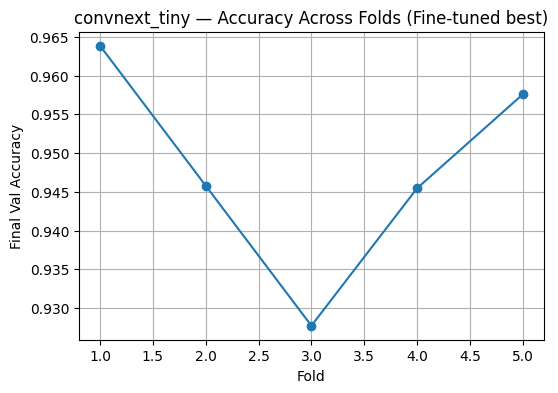

In [16]:
model_name = "convnext_tiny" 
k = 5                
epochs_frozen = 10     
epochs_ft = 20          
batch_size = 32
img_size = (224, 224)
base_lr = 1e-3
ft_lr = 1e-4
weight_decay = 1e-4     
pretrained = True

run_kfold_training(
    model_name=model_name,
    dataset_path=dataset_path,
    k=k,
    epochs_frozen=epochs_frozen,
    epochs_ft=epochs_ft,
    batch_size=batch_size,
    img_size=img_size,
    base_lr=base_lr,
    ft_lr=ft_lr,
    weight_decay=weight_decay,
    pretrained=pretrained
)


- ViT-B16

- CoatNeT